In [84]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [4]:
IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [5]:
def import_dataset(path, IMG_SIZE=256,BATCH_SIZE=32):
  dataset=tf.keras.preprocessing.image_dataset_from_directory(
      path,
      shuffle=True,
      image_size=(IMG_SIZE,IMG_SIZE),
      batch_size=BATCH_SIZE
  )
  return dataset

In [6]:
dataset=import_dataset("/content/drive/MyDrive/cotton disease_1",IMG_SIZE,BATCH_SIZE)

Found 154 files belonging to 4 classes.


# Visualization

In [7]:
class_names=dataset.class_names
print(class_names)

['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']


In [8]:
for image, label in dataset.take(1):
  print(image.shape)
  print(label.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [9]:
def visualize_data(dataset):
  plt.figure(figsize=(15,10))
  for image, label in dataset.take(1):
    for i in range(10):
      ax=plt.subplot(2,5,i+1)
      plt.imshow(image[i].numpy().astype("uint8"))
      plt.title(class_names[label[i]])
      plt.axis("off")


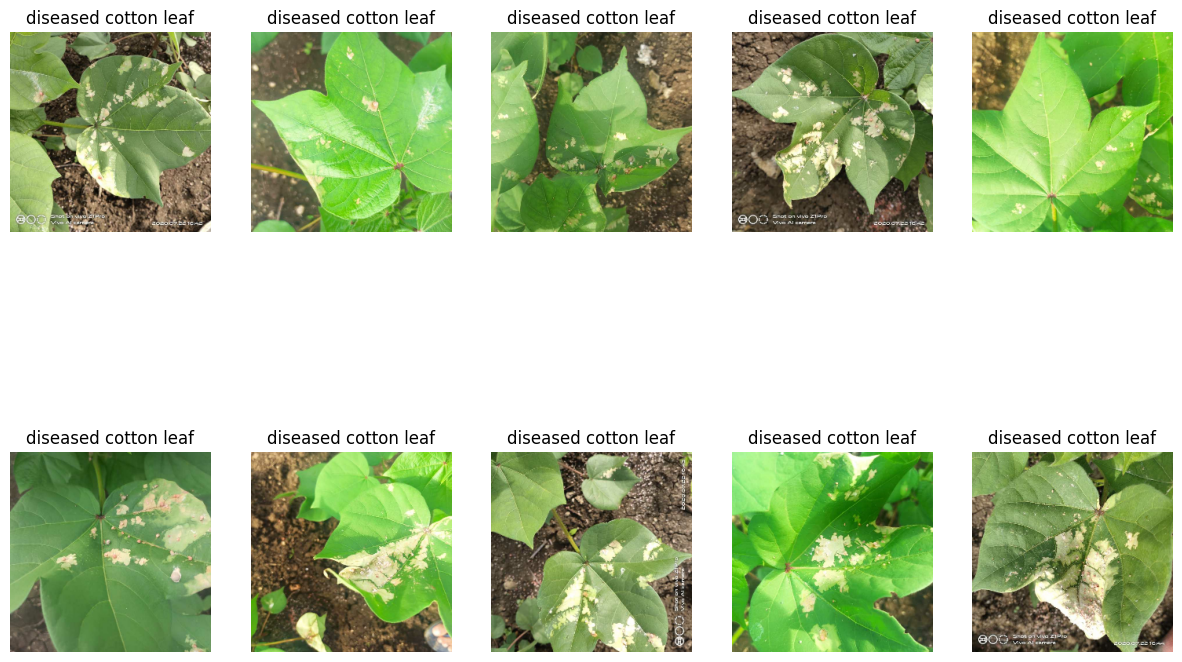

In [10]:
visualize_data(dataset)

# Split the Data

In [11]:
! pip install split-folders
import splitfolders

In [12]:
# import splitfolders

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio("/content/drive/MyDrive/cotton disease_1", output="/content/drive/MyDrive/DATASET",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [70]:
IMAGE_SIZE=256
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.0, 0.8)
)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/DATASET/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 122 images belonging to 4 classes.


In [71]:
train_generator.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [72]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.0, 0.8))
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/DATASET/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 14 images belonging to 4 classes.


In [19]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.0, 0.8))

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/DATASET/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 18 images belonging to 4 classes.


# Optimize the Data


In [20]:
# train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Build

# Model-1

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model1.build(input_shape=input_shape)

In [22]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compile

In [75]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
train_generator.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [76]:
history = model1.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    verbose=1,
    epochs=50,
)

Epoch 1/50
4/4 [==============================] - 7s 962ms/step - loss: 0.3731 - accuracy: 0.9344 - val_loss: 0.1648 - val_accuracy: 1.0000
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 0.3470 - accuracy: 0.9344 - val_loss: 0.0775 - val_accuracy: 1.0000
Epoch 3/50
4/4 [==============================] - 4s 1s/step - loss: 0.3486 - accuracy: 0.9344 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 4/50
4/4 [==============================] - 5s 1s/step - loss: 0.3255 - accuracy: 0.9344 - val_loss: 0.1080 - val_accuracy: 1.0000
Epoch 5/50
4/4 [==============================] - 4s 949ms/step - loss: 0.3300 - accuracy: 0.9344 - val_loss: 0.1187 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 4s 1s/step - loss: 0.3200 - accuracy: 0.9344 - val_loss: 0.0424 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 4s 1s/step - loss: 0.3384 - accuracy: 0.9344 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 8/50
4/4 [===================

## Plot

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

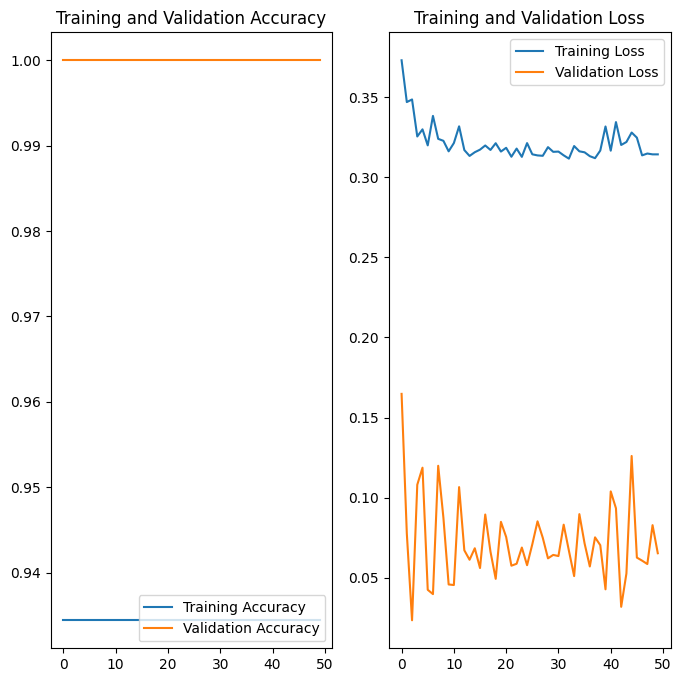

In [78]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
EPOCHS=50
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference

In [86]:
def predict(model, img):
    #convert image into array
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


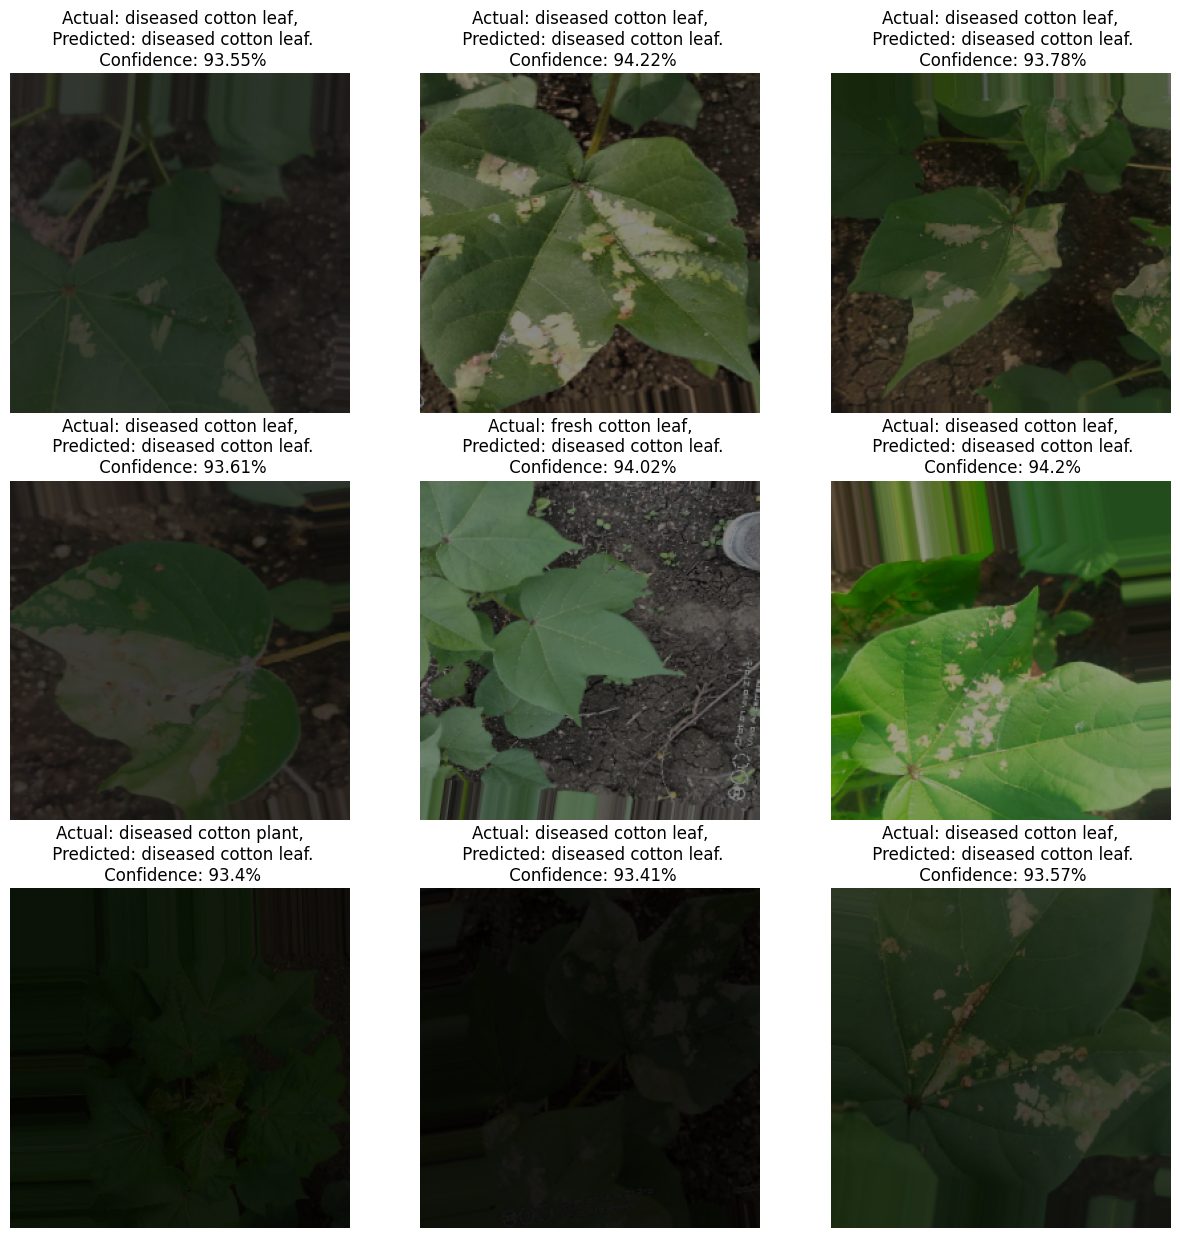

In [87]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model1, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

In [80]:
scores = model1.evaluate(test_generator)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


1/1 [==============================] - 1s 671ms/step - loss: 0.7066 - accuracy: 0.8333
Test loss: 0.7065815329551697
Test accuracy: 0.8333333134651184


In [88]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
testy = []
for image_batch, label_batch in test_generator:
    testy.append(label_batch)

testy = np.array(testy)
yhat_probs = []
for image_batch in test_generator:
    yhat_probs.append(model1.predict(image_batch))

yhat_probs = np.array(yhat_probs)
yhat_probs = yhat_probs[:, 0]

yhat_classes = []
for image_batch in test_generator:
    yhat_classes.append(model1.predict_classes(image_batch))

yhat_classes = np.array(yhat_classes)
yhat_classes = yhat_classes[:, 0]

# Calculate the recall and precision
recall = recall_score(testy, yhat_classes, multi_class="ovo")
print('Recall:', recall)

precision = precision_score(testy, yhat_classes, multi_class="ovo")
print('Precision:', precision)

KeyboardInterrupt: ignored

first image to predict
actual label: diseased cotton leaf
1/1 [==============================] - 0s 399ms/step
predicted label: diseased cotton leaf


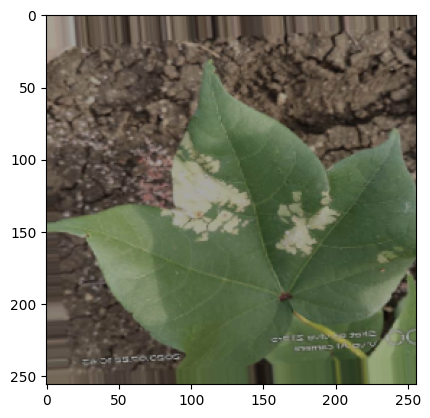

In [81]:
for i in range(len(test_generator)):
    image_batch, label_batch = test_generator[i]

    first_image = image_batch[0]
    first_label = int(label_batch[0])

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model1.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Save Model

In [94]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/DATASET/models/") + [0]])+1
model1.save(f"/content/drive/MyDrive/DATASET/models/{model_version}")

# Model-2

In [96]:
import tensorflow as tf
import tensorflow_hub as hub


In [103]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

# Load the pre-trained model from TensorFlow Hub
model = hub.KerasLayer("https://tfhub.dev/rishit-dagli/plant-disease/1", trainable=False)


In [107]:

NUM_CLASSES = 4  # Change this to the appropriate number of classes

model2 = models.Sequential([
    model,

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Input shape should be (None, 224, 224, 3)
model2.build(input_shape=(None, 224, 224, 3))
model2.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 38)                3267814   
                                                                 
 flatten_8 (Flatten)         (None, 38)                0         
                                                                 
 dense_30 (Dense)            (None, 256)               9984      
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 256)              

In [108]:
model2.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [109]:
history = model2.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/50
4/4 [==============================] - 13s 1s/step - loss: 1.2505 - accuracy: 0.8033 - val_loss: 1.0643 - val_accuracy: 1.0000
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 0.9492 - accuracy: 0.9344 - val_loss: 0.5996 - val_accuracy: 1.0000
Epoch 3/50
4/4 [==============================] - 6s 993ms/step - loss: 0.5988 - accuracy: 0.9344 - val_loss: 0.2252 - val_accuracy: 1.0000
Epoch 4/50
4/4 [==============================] - 4s 927ms/step - loss: 0.3833 - accuracy: 0.9344 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 5/50
4/4 [==============================] - 5s 1s/step - loss: 0.3231 - accuracy: 0.9344 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 4s 949ms/step - loss: 0.3507 - accuracy: 0.9344 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 5s 1s/step - loss: 0.3734 - accuracy: 0.9344 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 8/50
4/4 [===============

In [110]:
scores = model2.evaluate(test_generator)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


1/1 [==============================] - 2s 2s/step - loss: 0.5922 - accuracy: 0.8333
Test loss: 0.5922355651855469
Test accuracy: 0.8333333134651184


In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

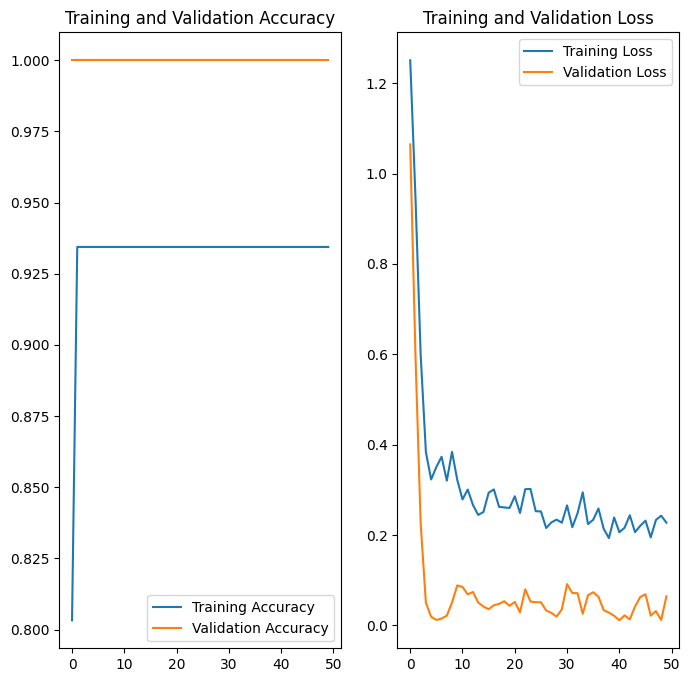

In [113]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Inference Model 2

1/1 [==============================] - 0s 32ms/step


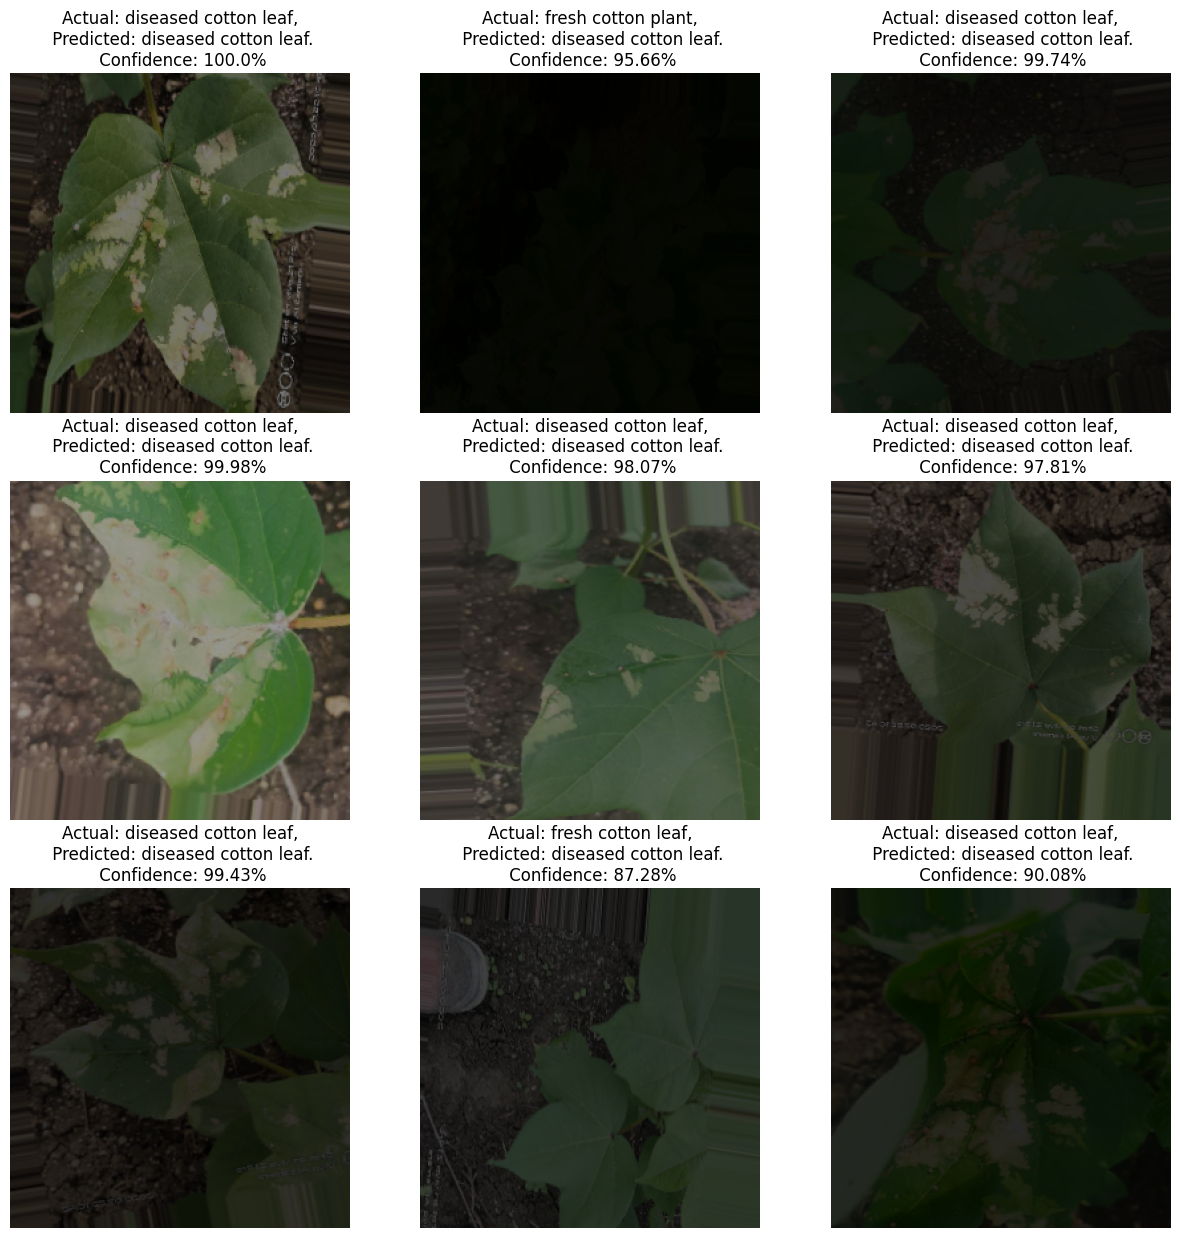

In [114]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model2, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

# Save Model-2

In [118]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/DATASET/models/") + [0]])+1
model2.save(f"/content/drive/MyDrive/DATASET/models/{model_version}")

In [119]:
model2.save("/content/drive/MyDrive/DATASET/crops.h5")